In [37]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def make_weight_matrix(n_src, n_target, w_min=0.0, w_max=1.0, prob=0.5, seed=0):
    torch.manual_seed(seed)
    prob_mask = (torch.rand((n_src, n_target)) < prob).float()
    weight_matrix = torch.rand((n_src, n_target)) * (w_max - w_min) + w_min

    return weight_matrix * prob_mask

In [71]:
class model_network(nn.Module):
    def __init__(self, snn_dict, neuron_dict, conn_dict, rec_dict, num_steps=500, device='cpu'):
        super(model_network, self).__init__()
        self.snn_dict = snn_dict
        self.neuron_dict = neuron_dict
        self.conn_dict = conn_dict
        self.rec_dict = rec_dict
        self.num_steps = num_steps

    def forward(self):
        self.rec_init()
        # network simulation
        for step in range(1, self.num_steps):
            for target_name in self.neuron_dict.keys():
                cur = torch.matmul(self.rec_dict[target_name]['spk_bkg'][step],
                                    self.neuron_dict[target_name]['bkg_weight'])
                
                for src_name in self.neuron_dict.keys():
                    conn_name = f'{src_name}{target_name}'
                    weight = self.conn_dict[conn_name]['weight']

                    cur += torch.matmul(self.rec_dict[src_name]['spk'][-1], weight)

                spk, mem = self.snn_dict[target_name](cur, self.rec_dict[target_name]['mem'][-1])

                self.rec_dict[target_name]['mem'].append(mem)
                self.rec_dict[target_name]['spk'].append(spk)

        # convert lists to tensors
        for cell_name in self.snn_dict.keys():
            self.rec_dict[cell_name]['mem'] = torch.stack(self.rec_dict[cell_name]['mem']).squeeze()
            self.rec_dict[cell_name]['spk'] = torch.stack(self.rec_dict[cell_name]['spk']).squeeze()
                
        return self.rec_dict

    def rec_init(self):
        for cell_name in self.snn_dict.keys():
            cur = torch.matmul(self.rec_dict[cell_name]['spk_bkg'][0], self.neuron_dict[cell_name]['bkg_weight'])
            spk, mem = self.snn_dict[cell_name](cur, self.snn_dict[cell_name].init_leaky())

            self.rec_dict[cell_name]['mem'] = [mem]
            self.rec_dict[cell_name]['spk'] = [spk] 


In [72]:
def make_network():
    n_E = 1000
    n_I = 300

    num_steps = 500

    neuron_dict = {
        'E': {'threshold': 1.0, 'beta': 0.99, 'num_neuron': n_E, 'bkg_prob': 0.9, 'bkg_min': 0.0, 'bkg_max': 0.3, 'bkg_rate': 0.5},
        'I': {'threshold': 1.0, 'beta': 0.99, 'num_neuron': n_I, 'bkg_prob': 0.9, 'bkg_min': 0.0, 'bkg_max': 0.3, 'bkg_rate': 0.5},
    }

    conn_dict = {
        'EI': {'w_min': 0.0, 'w_max': 10.0, 'prob': 0.3},
        'IE': {'w_min': -10.0, 'w_max': 0.0, 'prob': 0.8},
        'EE': {'w_min': 0.0, 'w_max': 10.0, 'prob': 0.1},
        'II': {'w_min': -10.0, 'w_max': 0.0, 'prob': 0.8},
    }

    snn_dict = dict()
    rec_dict = dict()
    
    seed_count = 0
    for src_name, src_dict in neuron_dict.items():
        snn_dict[src_name] = snn.Lapicque(beta=src_dict['beta'], threshold=src_dict['threshold'])


        spk_bkg = spikegen.rate_conv(torch.ones((num_steps, src_dict['num_neuron'])) * src_dict['bkg_rate']).unsqueeze(1)
        bkg_weight = make_weight_matrix(
                        n_src=src_dict['num_neuron'],
                        n_target=src_dict['num_neuron'],
                        w_min=src_dict['bkg_min'],
                        w_max=src_dict['bkg_max'],
                        prob=src_dict['bkg_prob'],
                        seed=seed_count)
        neuron_dict[src_name]['bkg_weight'] = bkg_weight

        seed_count += 1
        rec_dict[src_name] = {'mem': list(), 'spk': list(), 'spk_bkg': spk_bkg}
        for target_name, target_dict in neuron_dict.items():
            conn_name = f'{src_name}{target_name}'
            conn_dict[conn_name]['weight'] = make_weight_matrix(
                n_src=src_dict['num_neuron'],
                n_target=target_dict['num_neuron'],
                w_min=conn_dict[conn_name]['w_min'],
                w_max=conn_dict[conn_name]['w_max'],
                prob=conn_dict[conn_name]['prob'],
                seed=seed_count
            )
        seed_count += 1

    net = model_network(snn_dict, neuron_dict, conn_dict, rec_dict, num_steps=num_steps)

    return net

In [73]:
net = make_network()

In [77]:
out = net()

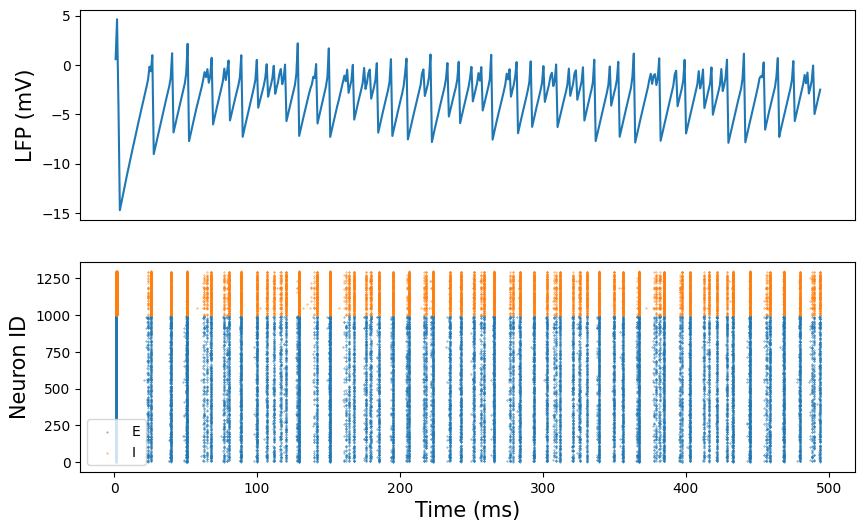

In [78]:
fontsize=15
plt.figure(figsize=(10, 6))

plt.subplot(2,1,2)
neuron_count = 0
mem_list = list()
for cell_name in net.snn_dict.keys():
    t_idx, unit_idx = np.where(net.rec_dict[cell_name]['spk'].detach().numpy() == 1.0)
    plt.scatter(t_idx, unit_idx + neuron_count, s=0.1, label=cell_name)

    neuron_count += net.neuron_dict[cell_name]['num_neuron']

    mem_list.append(net.rec_dict[cell_name]['mem'])

plt.legend()
plt.xlabel('Time (ms)', fontsize=fontsize)
plt.ylabel('Neuron ID', fontsize=fontsize)

plt.subplot(2,1,1)
plt.plot(torch.concat(mem_list,dim=1).mean(dim=1).detach().numpy())
plt.ylabel('LFP (mV)', fontsize=fontsize)
_ = plt.xticks([])

